# 9.2. UE Side: Downlink Data Communication in 5G Networks

In this project we will demonstrate the transmission and reception of the data from base-station (BS) using low cost SDRs. The whole simulation consists of two parts:

**Transmitter side**:

1. Generate the SSB block
2. Generate the transport block ==> Process it with PDSCH chain ==> Create the slot resource grids
3. Generate the resource grid and load SSB + PDSCH both into it.
4. Pass the resource grid through the OFDM modulator: Generate the time domain I/Q samples.
5. Pass it to the SDR and radiate the signal to the medium.

**Receiver side**:

1. Sample the medium to receive the samples and store thm in the buffer.
2. Downlink synchronization
    - This is performed using synchronization signal block (SSB).
    - Helps with 
        - time/frame synchronization.
        - Coarse CFO correction.
        - Cell ID detection.
        - Decoding MIB information.
3. Data transmission and decoding
    - 

![SSB Transmitter](images/Procedure.png)

## 9.2. Import Python Libraries

In [1]:
# %matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))

## 9.2. 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


from toolkit5G.PhysicalChannels.PDSCH import ComputeTransportBlockSize
from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy
from toolkit5G.Configurations         import PDSCHLowerPhyConfiguration, PDSCHUpperPhyConfiguration
from toolkit5G.SymbolMapping          import Mapper, Demapper
from toolkit5G.Scrambler              import DeScrambler, Scrambler
from toolkit5G.SymbolMapping          import Demapper
from toolkit5G.PhysicalChannels.PDSCH import LayerDemapper

from toolkit5G.PhysicalChannels   import PBCHDecoder
from toolkit5G.OFDM               import OFDMDemodulator
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualizationPBCH, DMRSParameterDetection, CarrierFrequencyOffsetEstimation, ChannelEstimationAndEqualizationPDSCH

from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy


## 9.2. Emulation Parameters

In [3]:
# Carrier Frequency
carrierFrequency = 1*10**9
numBatches       = 9          # Number of batches considered for simulation
scs              = 15*10**3   # Subcarrier Spacing for simulation
numBSs           = 1          # Number of BSs considered for simulation
bandwidth        = 30*10**6

# Number of UEs considered for simulation
numUEs           = numBatches # For now we are assuming that the numbatches are captured via numUEs
numRB            = 170        # Number of Resource mapping considered for simulation | # 1 RB = 12 subcarrier
slotNumber       = 0          # Index of the slot considered for simulation
Nfft             = 2048       # FFTSize

Nt               = 1

print("************ Simulation Parameters *************")
print()
print("     numBatches: "+str(numBatches))
print("          numRB: "+str(numRB))
print("       fft Size: "+str(Nfft))
print("         numBSs: "+str(numBSs))
print("         numUEs: "+str(numUEs))
print("            scs: "+str(scs))
print("     slotNumber: "+str(slotNumber))
print("Num of Antennas: "+str(Nt))
print()
print("********************************************")

************ Simulation Parameters *************

     numBatches: 9
          numRB: 170
       fft Size: 2048
         numBSs: 1
         numUEs: 9
            scs: 15000
     slotNumber: 0
Num of Antennas: 1

********************************************


## Time-Frequency Parameters

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame   = 14
numOFDMSymbols = 14
tfParams    = TimeFrequency5GParameters(bandwidth, scs, fftsize=Nfft)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = nRB*12
lengthCP    = (tfParams.lengthCP).astype(np.int32)    # CP length
#___________________________________________________________________

print("number of RBs:"+str(nRB))
print("     FFT size:"+str(Nfft))
print("length of CP :"+str(lengthCP[1]))

number of RBs:160
     FFT size:2048
length of CP :144


## 9.2. Generate the PDSCH related parameters: Use PDSCH Configurations

In [5]:
######################################### PDSCH Lower Physical Layer Parameters #########################################
pdschMappingType       = 'PDSCH-mapping-type-B'   # "PDSCH mapping type A" or "PDSCH mapping type B"
maxLength              = 'len1'                   #
startSymbol            = 2                        # 
numSymbols             = 12                       # 
betaDMRS               = 1                        # 0 to 1
configurationType      = "Configuration-type-1"   # "Configuration-type-1" or "Configuration-type-2"
dmrsTypeAPosition      = "pos2"                   # "pos2" or "pos3"
dmrsAdditionalPosition = 'pos1'                   # "pos0", "pos1", "pos2" or "pos3"
ld                     = numSymbols
l0                     = startSymbol
l1                     = 11
rank                   = 1
pdschLowerPhyConfig    = PDSCHLowerPhyConfiguration(pdschMappingType = pdschMappingType, maxLength = maxLength, 
                                                    betaDMRS = betaDMRS, configurationType = configurationType, 
                                                    dmrsTypeAPosition = dmrsTypeAPosition, rank = rank,
                                                    dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, 
                                                    l1 = l1, startSymbol = startSymbol, numSymbols= numSymbols, 
                                                    ld = ld, scramblingID = 0, nSCID = 0)
scramblingID           = pdschLowerPhyConfig.scramblingID
nSCID                  = pdschLowerPhyConfig.nSCID


######################################### PDSCH Upper Physical Layer Parameters #########################################

numTBs                 = 1
mcsIndex               = 15
mcsTable               = 'pdschTable1'
scalingField           = '00'
additionalOverhead     = 0
scalingField           = None
additionalOverhead     = None

pdschUpperPhyConfig    = PDSCHUpperPhyConfiguration(pdschMappingType = pdschMappingType, configurationType = configurationType, 
                                                    dmrsTypeAPosition = dmrsTypeAPosition, maxLength = maxLength, numTBs = numTBs,
                                                    mcsIndex = mcsIndex, dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, 
                                                    mcsTable = mcsTable, ld = ld, l1 = l1, startSymbol = startSymbol, numRB = numRB,
                                                    numSymbols = numSymbols, rank = rank, scalingField = scalingField, 
                                                    additionalOverhead = additionalOverhead)

numTBs                 = pdschUpperPhyConfig.numTBs
mcsIndex               = pdschUpperPhyConfig.mcsIndex
mcsTable               = pdschUpperPhyConfig.mcsTable

numlayers              = pdschUpperPhyConfig.numlayers
tbLen1                 = pdschUpperPhyConfig.tbLen1
codeRate               = pdschUpperPhyConfig.codeRate
modOrder               = pdschUpperPhyConfig.modOrder

scalingField           = pdschUpperPhyConfig.scalingField
additionalOverhead     = pdschUpperPhyConfig.additionalOverhead
dmrsREs                = 6
dmrsREs                = pdschUpperPhyConfig.dmrsREs
scalingField           = pdschUpperPhyConfig.scalingField


numTargetBits1         = pdschUpperPhyConfig.numTargetBits1
if(numTBs == 2):
    numTargetBits1     = pdschUpperPhyConfig.numTargetBits1
    numTargetBits2     = pdschUpperPhyConfig.numTargetBits2
    tbLen2             = pdschUpperPhyConfig.tbLen2

numTargetBits          = pdschUpperPhyConfig.numTargetBits

## --------------------------------------------------------
bwpOffset              = np.int32(0.5*(Nfft-numRB*12))

rnti                   = 0
nID                    = 0


************ PDSCH Parameters *************

       pdschMappingType: PDSCH-mapping-type-B
            startSymbol: 2
             numSymbols: 12
               betaDMRS: 1
                   rank: 1
      configurationType: Configuration-type-1
              maxLength: len1
      dmrsTypeAPosition: pos2
 dmrsAdditionalPosition: pos1
           Duration, ld: 12
       Start symbol, l0: 2
     Start symbol-1, l1: 11
          num of Layers: 1

********************************************
********************************************
          tbsize-1: 54296

            numTBs: 1
            numCBs: 7
         numLayers: 1 | LayerperTB: [1 0]
             numRB: 170
          coderate: 0.6015625
          modOrder: 4
additionalOverhead: 0
numberTargetBits: 89760
********************************************


## 9.2. SDR-Setup Configurations

In [6]:
## SDR Parameters
sample_rate         = Nfft*scs

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(Nfft*1.2*numSamplesPerSymbol*140) 

# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate     = int(sample_rate)

# # Config Rx
# sdr.gain_control_mode_chan0 = 'manual'
# sdr.rx_hardwaregain_chan0   = 40.0      # dB
# # The receive gain on the Pluto has a range from 0 to 74.5 dB.

sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(carrierFrequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(4*buffer_size)

## 9.2. Receiver Implementation: SSB
![Receiver_Implementation](images/PBCH_SDR_Rx.svg)

## 9.2. Reception: SDR RF Receiver

In [7]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # # Stop transmitting
# sdr.tx_destroy_buffer()


## 9.2. Time Synchronization: Based on PSS Correlation

**(rasterOffset, PSS-ID) (904, 0)
**(rasterOffset, PSS-ID) (904, 1)
**(rasterOffset, PSS-ID) (904, 2)


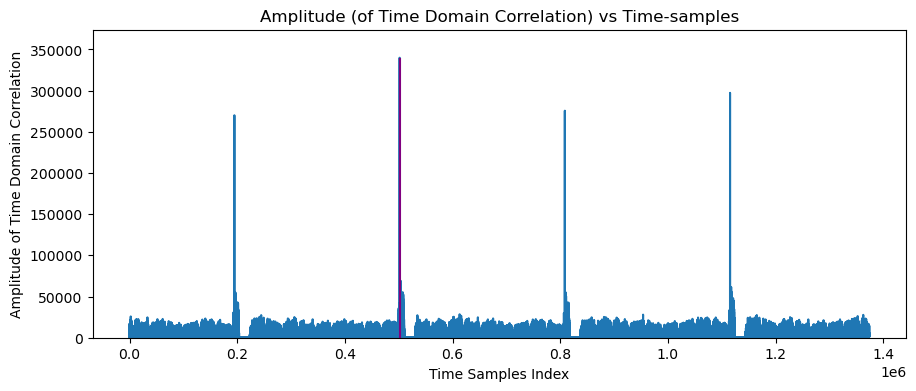

In [8]:
## PSS Detection: Based on time domain PSS Correlation
# pssPeakIndices, pssCorrelation, rN_ID2 = pssDetection(r, Nfft, lengthCP = lengthCP[1],
#                                                       N_ID2 = None, freqOffset = ssboffset,
#                                                       height = 0.75, prominence = 0.65, width=10)
## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")
pssDetection   = PSSDetection("largestPeak")
offsetInRBs    = int((nRB-20)/2)
ssboffset      = int((Nfft-Neff)/2+offsetInRBs*12)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, Nfft, lengthCP = lengthCP[1],
                                                                  nID2 = None, freqOffset = ssboffset)

# if(pssPeakIndices > rx_samples.size - 140*(Nfft + lengthCP[1])):
#     pssPeakIndices = pssPeakIndices - 140*(Nfft + lengthCP[1])

## PSS Detection Plot
#################################################################
fig, ax = plt.subplots(figsize = (10.5, 4))

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________

## 9.2. PBCH Receiver

1. OFDM Demodulation
2. SSS Dtection
3. DMRS Parameters Detection
4. Channel Estimation and PBCH Equalization
4. PBCH Decoding and MIB Extraction

In [9]:
## Carrier frequency offset (CFO) estimation

## Parameters for computing CFO
cyclic_prefix_length      = lengthCP[1]                                     #Length of cyclic prefix
numSamples                = Nfft + cyclic_prefix_length                  #OFDM samples of 1 symbol
firstIndex                = pssPeakIndices                                  #PSS detection
pssOfdmSymbols            = rx_samples[firstIndex: firstIndex + numSamples] #PSS samples

obj                       = CarrierFrequencyOffsetEstimation(Nfft, cyclic_prefix_length)
cfoEst                    = obj(pssOfdmSymbols,numCFOIteration = 2)    ## Estimated CFO

## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(Nfft, lengthCP[1])
pssStartIndex   = pssPeakIndices
cfo             = cfoEst
indices         = np.arange(rx_samples.size)
rxGrid          = ofdmDemodulator((np.exp(-1j*cfo*indices/Nfft)*rx_samples.reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(Nfft+lengthCP[1]))])

ssbSCSoffset    = int((Nfft-Neff)/2 + offsetInRBs*12)
ssbEstimate     = rxGrid[:,:,ssbSCSoffset:(ssbSCSoffset+240)]

nssbCandidatesInHrf = 4
dmrsLen             = 144
## N_ID_1 Estimation: SSS based
sssDetection   = SSSDetection(method="channelAssisted", nID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices

## Generate DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate[0])
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen)

# ## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
# ## Object for Channel Estimation
chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile=True)
pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rN_ID)

## PBCH Chain for Decoding information
polarDecoder    = "SCL"
symbolDemapper  = "maxlog"
# extractMIBinfo = False
extractMIBinfo  = True
# carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
pbchDecoder     = PBCHDecoder(carrierFrequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check    = pbchDecoder(pbchEstimate, 10, extractMIBinfo)

<frozen toolkit5G.ChannelCoder.PolarCoder.polarDecoder>:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.


In [10]:
rN_ID

557

## 9.2. SSB Grid: Transmitter and Receiver

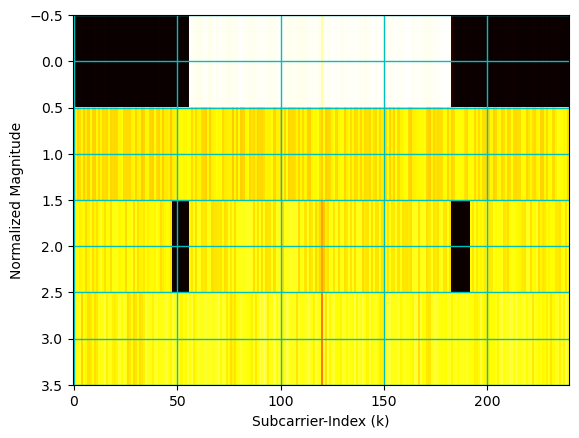

In [11]:
# Plot SSB
fig, ax = plt.subplots()
ax.imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")

plt.show()

## 9.2. Spectrum: Transmitted Grid and Received Grid

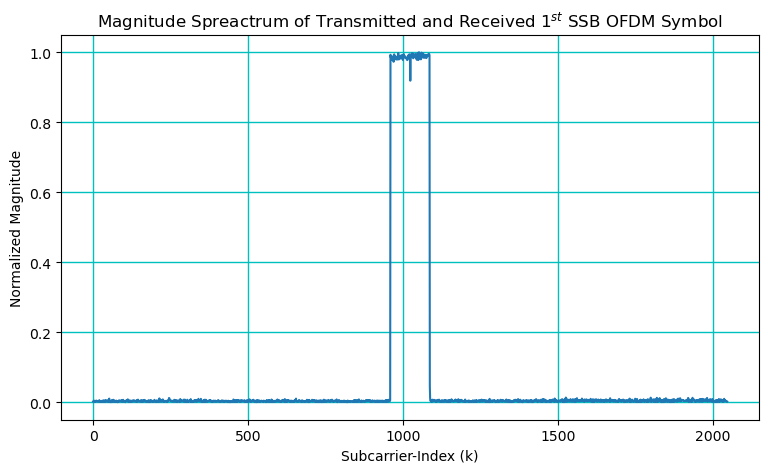

In [12]:
# Plot SSB
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(np.abs(rxGrid[0][0])/np.abs(rxGrid[0][0]).max())
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Magnitude Spreactrum of Transmitted and Received $1^{st}$ SSB OFDM Symbol")
plt.show()

## 9.2. PBCH Decoding and Constellation

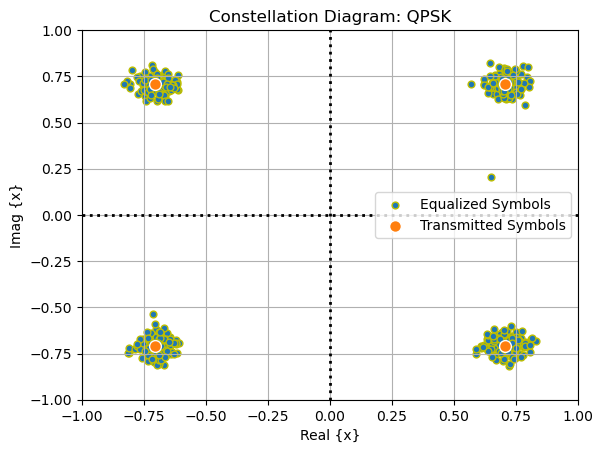

In [13]:
qpskSymbols = np.sqrt(0.5)*np.array([1+1j, -1+1j, 1-1j, -1-1j])
fig, ax = plt.subplots()
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate), s = 24, label = "Equalized Symbols", ec = "y")
ax.scatter(np.real(qpskSymbols),  np.imag(qpskSymbols),  s = 72, label = "Transmitted Symbols", ec = "w")
ax.grid()
ax.axhline(y=0, ls=":", c="k", lw = 2); ax.axvline(x=0, ls=":", c="k", lw = 2)
ax.set_xlim([-1,1]); ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}"); ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.legend(loc = "best")
plt.show()

In [14]:
pbchDecoder.mibRx.displayParameters(0)

Carrier Frequency:	1000000000
ChoiceBit:  		0
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:30000
DMRSTypeAPosition: 	typeB
controlResourceSet0:	6
searchSpace0: 		13
cellBarred: 		notBarred
intraFreqReselection: 	allowed
systemFrameNumber: 	243
ssbSubCarrierOffset: 	8
HRFBit: 		1
iSSBindex: 		0


## 9.2. PDSCH Receiver Implementation
### 9.2. Extract PDSCH Resource Grid

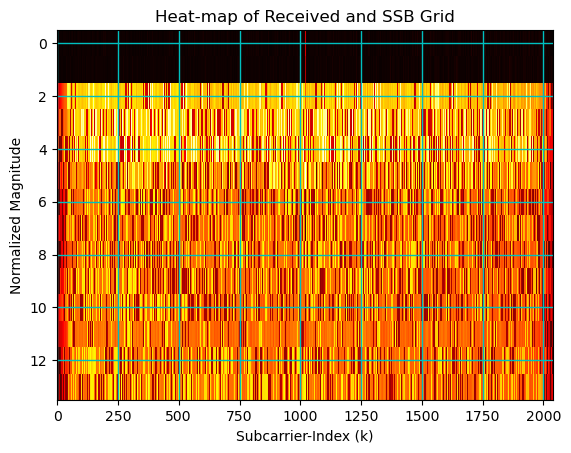

In [15]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(Nfft, lengthCP[1])
pdschStartIndex = pssStartIndex+12*(Nfft+lengthCP[1])
# pssStartIndex   = pssPeakIndices[0][0]
rxGrid          = ofdmDemodulator((np.exp(-1j*cfo*indices/Nfft)*rx_samples.reshape(1,-1))[...,pdschStartIndex:(pdschStartIndex+14*numBatches*(Nfft+lengthCP[1]))])

pdschGrid       = rxGrid[:,:,bwpOffset:bwpOffset+numRB*12].reshape(numBatches,1,14,-1)

# Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(pdschGrid[0,0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received and SSB Grid")
plt.show()

In [16]:
pdschGrid.shape

(9, 1, 14, 2040)

### 9.2. PDSCH Receiver

![PDSCH Receiver](images/PDSCH_Rx.png)

In [17]:
# Channel Estimation and Equalization
chEst = ChannelEstimationAndEqualizationPDSCH(slotNumber, scramblingID, nSCID, rnti, nID, 
                                              pdschMappingType, configurationType, dmrsTypeAPosition, 
                                              maxLength, dmrsAdditionalPosition, l0, ld, l1, 
                                              startSymbol, numTargetBits, modOrder)
interpolator = "linear" # Can be "nearest" | "linear" | "cubicspline"
polyOrder    = 3 # Required only for Spline, Will be ignored for other interpolators
rsymbols     = chEst(pdschGrid, interpolator)

#### Layer Demapping
layDemap     = LayerDemapper(numTBs, rank)
rlmSym       = layDemap(rsymbols)  # received symbols

######## Demapping.
demapMethod  = "app" # Demapping method
constType    = "qam"  # Symbol mapping type
modOrder     = modOrder       # Mordulation order or number of bits per symbol
snr          = 10
hard_out     = False
demapper     = Demapper(demapMethod, constType, modOrder, hard_out = hard_out)

## Computed Received bits
rxLLRs      = demapper([np.complex64(rlmSym), 1/snr])

## Descrambling
if hard_out:
    
    scrObject = Scrambler("PDSCH", rnti, 0, nID)
    rxBits    = scrObject(rxLLRs)

else:
    scrObject = DeScrambler("PDSCH", rnti, 0, nID)
    rscrBits  = scrObject(rxLLRs)
    rxBits    = np.where(rscrBits>0, 1, 0)

# PDSCH Upper Physical layer Decoder
pdschUpPhyDec = PDSCHDecoderUpperPhy(numTBs = numTBs, mcsIndex = mcsIndex, symbolsPerSlot= numSymbols, 
                                     numRB  = numRB, numLayers = numlayers, scalingField = scalingField, 
                                     additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
                                     enableLBRM = [False, False], pdschTable = mcsTable, rvid = [0, 0], verbose=False)
rbits         = pdschUpPhyDec([rscrBits])

### 9.2. Constellation Diagram

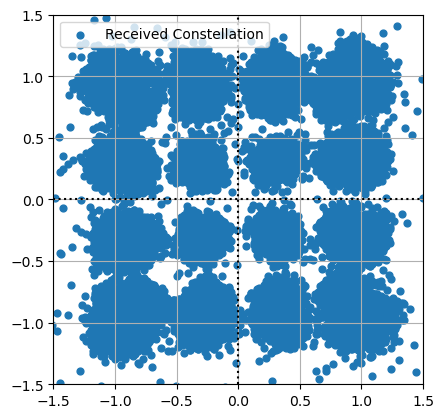

In [18]:
fig, ax = plt.subplots()
ax.set_aspect(True)
ax.scatter(np.real(rsymbols), 
           np.imag(rsymbols), s=24, label="Received Constellation")
# equalizedSamples = rsymbols.flatten()
# indices = np.random.choice(equalizedSamples.size, size = 10000, replace = False)
# ax.scatter(np.real(equalizedSamples[indices]), 
#            np.imag(equalizedSamples[indices]), s=24, label="Received Constellation")
ax.axhline(y=0, ls=":", c="k"); ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1.5,1.5]); ax.set_ylim([-1.5,1.5])
# ax.set_xlim([-2,2]); ax.set_ylim([-2,2])
# ax.set_xlabel("Real {x}"); ax.set_ylabel("Imag {x}")
# if modOrder ==2:
#     ax.set_title("Constellation Diagram: QPSK")
# else:
#     ax.set_title("Constellation Diagram: "+str(pow(2,modOrder))+str(" QAM"))

ax.grid(); 
ax.legend(loc = "best")
plt.show()

## 9.2. Key Performance Indicators

1. Data-rate Indicators
    - Thoughput (Bits per seconds)
    - Spectral Efficency (Bits per second per Hertz)
2. Reliability
    - Block Error Rate (BLER)
    - Bit Error Rate (BER)

In [19]:
# Reliability Metrics
bler              = 1-np.mean(pdschUpPhyDec.crcCheckTBs)

# Data rate Metrics
maxThroughput     = (14*numRB*12)*modOrder*codeRate*1000*15000/scs
slotDuration      = 10**(-3)*15000/(scs)
throughput        = (1-bler)*numBatches*tbLen1/(slotDuration*(numBatches+1))
spectalEfficiency = throughput/bandwidth

print()
print("         Throughput: "+str(throughput/10**6)+" Mbps")
print("Spectral Efficiency: "+str(spectalEfficiency)+" bits per second per Hz")
print()
print("*********************** Reliability ***********************")
print("   Block Error Rate: "+str(bler))
print()



         Throughput: 48.8664 Mbps
Spectral Efficiency: 1.62888 bits per second per Hz

*********************** Reliability ***********************
   Block Error Rate: 0.0



## 9.2. Quasi-realtime simulation

In [20]:
# # function that draws each frame of the animation
# numSamples   = Nfft + lengthCP[1]

# #
# pssDetection = PSSDetection("largestPeak")

# # Channel Estimation and Equalization
# chEst = ChannelEstimationAndEqualizationPDSCH(slotNumber, scramblingID, nSCID, rnti, nID, 
#                                               pdschMappingType, configurationType, dmrsTypeAPosition, 
#                                               maxLength, dmrsAdditionalPosition, l0, ld, l1, 
#                                               startSymbol, numTargetBits, modOrder)

# def animate(i):
#     # Receive samples
#     rx_samples = sdr.rx()

#     pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, Nfft, lengthCP = lengthCP[1],
#                                                                   nID2=None, freqOffset = ssboffset)


#     if(pssPeakIndices > rx_samples.size - 140*(Nfft + lengthCP[1])):
#         pssPeakIndices = pssPeakIndices - 140*(Nfft + lengthCP[1])

#     # CFO estimation
#     obj    = CarrierFrequencyOffsetEstimation(Nfft,lengthCP[1])
#     cfoEst = obj(rx_samples[pssPeakIndices: pssPeakIndices + numSamples],numCFOIteration = 2)  # Computed CFO

#     ## OFDM Demodulator Object
#     ofdmDemodulator = OFDMDemodulator(Nfft, lengthCP[1])
#     pdschStartIndex = pssPeakIndices + 12*(Nfft+lengthCP[1])
#     rxGrid          = ofdmDemodulator((rx_samples.reshape(1,-1))[...,pdschStartIndex:(pdschStartIndex+14*numBatches*(Nfft+lengthCP[1]))])

#     pdschGrid       = rxGrid[:,:,bwpOffset:bwpOffset+numRB*12].reshape(numBatches,1,14,-1)

#     interpolator = "linear" # Can be "nearest" | "linear" | "cubicspline"
#     polyOrder    = 3 # Required only for Spline, Will be ignored for other interpolators
#     rsymbols     = chEst(pdschGrid, interpolator)

#     #### Layer Demapping
#     layDemap     = LayerDemapper(numTBs, rank)
#     rlmSym       = layDemap(rsymbols)  # received symbols

#     ######## Demapping.
#     demapMethod  = "app" # Demapping method
#     constType    = "qam"  # Symbol mapping type
#     snr          = 10
#     hard_out     = False
#     demapper     = Demapper(demapMethod, constType, modOrder, hard_out = hard_out)

#     ## Computed Received bits
#     rxLLRs      = demapper([np.complex64(rlmSym), 1/snr])

#     ## Descrambling
#     if hard_out:

#         scrObject = Scrambler("PDSCH", rnti, 0, nID)
#         rxBits    = scrObject(rxLLRs)

#     else:
#         scrObject = DeScrambler("PDSCH", rnti, 0, nID)
#         rscrBits  = scrObject(rxLLRs)
#         rxBits    = np.where(rscrBits>0, 1, 0)

#     # PDSCH Upper Physical layer Decoder
#     pdschUpPhyDec = PDSCHDecoderUpperPhy(numTBs = numTBs, mcsIndex = mcsIndex, symbolsPerSlot= numSymbols, 
#                                          numRB  = numRB, numLayers = numlayers, scalingField = scalingField, 
#                                          additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
#                                          enableLBRM = [False, False], pdschTable = mcsTable, rvid = [0, 0], verbose=False)
#     rbits         = pdschUpPhyDec([rscrBits])
    
#     # Reliability Metrics
#     bler              = 1-np.mean(pdschUpPhyDec.crcCheckTBs)

#     # Data rate Metrics
#     maxThroughput     = (14*numRB*12)*modOrder*codeRate*1000*15000/scs
#     slotDuration      = 10**(-3)*15000/(scs)
#     throughput        = (1-bler)*numBatches*tbLen1/(slotDuration*(numBatches+1))
#     spectalEfficiency = throughput/bandwidth
    
#     ax[0].clear()
#     ax[0].set_xlim([-1.5, 1.5])
#     ax[0].set_ylim([-1.5, 1.5])
#     ax[0].scatter(np.real(rsymbols.flatten()), np.imag(rsymbols.flatten()), s=24, label="Received Constellation")
    
#     ax[0].axhline(y=0, ls=":", c="k"); 
#     ax[0].axvline(x=0, ls=":", c="k")
    
#     ax[0].set_xlabel("Real {x}"); ax[0].set_ylabel("Imag {x}")
#     if modOrder ==2:
#         ax[0].set_title("Constellation Diagram: QPSK")
#     else:
#         ax[0].set_title("Constellation Diagram: "+str(pow(2,modOrder))+str(" QAM"))

#     ax[0].grid()
#     ax[0].legend(loc = "best")
    
#     # Reliability Metrics
#     bler              = 1-np.mean(pdschUpPhyDec.crcCheckTBs)

#     # Data rate Metrics
#     slotDuration      = 10**(-3)*15000/(scs)
#     throughput        = (1-bler)*numBatches*tbLen1/(slotDuration*(numBatches+1))
#     spectalEfficiency = throughput/bandwidth
    
#     data[0] = throughput/maxThroughput
#     data[1] = 1 - data[0]
#     ax[1].pie(data, wedgeprops=dict(width=0.33, edgecolor='r'), startangle=90, colors = colors[0:2])
#     ax[1].set_title("Throughput Performance")
    
#     data[0] = bler
#     data[1] = 1-bler
#     ax[2].pie(data, wedgeprops=dict(width=0.33, edgecolor='k'), startangle=90, colors = colors[2:4])
#     ax[2].set_title("BLER Performance")

# # Plot SSB
# fig, ax = plt.subplots(1,3, figsize=(10, 3.3), subplot_kw=dict(aspect="equal"))
# ax[0].set_aspect(True)
# ax[1].set_aspect(True)
# ax[2].set_aspect(True)

# scale = 100
# maxThroughput = (14*numRB*12)*modOrder*codeRate*1000*15000/scs
# data    = [0.75,0.25]

# cmap    = plt.get_cmap("tab20c")
# colors  = cmap(np.arange(4)*3)
# #####################
# # run the animation
# #####################
# # frames= 20 means 20 times the animation function is called.
# # interval=500 means 500 milliseconds between each frame.
# # repeat=False means that after all the frames are drawn, the animation will not repeat.
# # Note: plt.show() line is always called after the FuncAnimation line.


# anim = animation.FuncAnimation(fig, animate, frames=1000, interval=1, repeat=False, blit=True)
# # saving to mp4 using ffmpeg writer
# plt.show()

# anim.save("[UE]PDSCH_Constellation.gif", fps = 10)

# # writervideo = animation.FFMpegWriter(fps=60)
# # anim.save('Overall.mp4', writer=writervideo)

![UE-PDSCH_Constellation](UE-PDSCH_Constellation.gif)